# Tapered Linear $\omega$ Models

**Objective:** The pure linear model ($V = V_{\text{bary}} + \omega R$) validated in Notebook 02
grows unboundedly at large radii. This notebook tests **tapered** variants that preserve
the linear inner behavior while asymptotically flattening — consistent with observed
flat rotation curves.

## Models Under Test

| Label | Name | Equation | Free Params | Physics |
|-------|------|----------|-------------|--------|
| **A** | Pure Linear | $V = V_{\text{bary}} + \omega R$ | $\omega$ (1) | Rigid body / Frame dragging |
| **B** | Rational Taper | $V = V_{\text{bary}} + \frac{\omega R}{1 + R/R_t}$ | $\omega, R_t$ (2) | Saturation: linear core → flat asymptote ($\omega R_t$) |
| **C** | Tanh Taper | $V = V_{\text{bary}} + V_{\max} \tanh(R / R_t)$ | $V_{\max}, R_t$ (2) | Shear layer: sharper transition to flat asymptote ($V_{\max}$) |

**Key question:** Does the extra parameter ($R_t$) improve the fit enough to justify
its inclusion? We use BIC to answer this.

**Physical hypothesis:** We test whether $R_t \approx 3 R_d$ (where $R_d$ is the disk
scale length), which would connect the taper scale to the baryonic disk and align
with Flynn's "0.3 normalized radius" observation.

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.physics import (
    compute_v_bary,
    fit_omega,
    fit_omega_tapered,
    fit_omega_tanh,
    compute_bic,
)
from src.utils import setup_logger

sns.set_theme(style='whitegrid', font_scale=1.1)
%matplotlib inline

# Mass-to-light ratios (fixed from Notebook 01 calibration)
UPSILON_DISK = 0.5
UPSILON_BULGE = 0.7

# M33 disk scale length (Corbelli & Salucci 2000)
R_D_M33 = 1.4  # kpc

## 1. Load M33 Calibrated Data

We use the radial profile exported from Notebook 01, which contains the
validated $V_{\text{bary}}$ computed via the Casertano (1983) thin-disk method.

In [2]:
profile = pd.read_csv('../results/tables/M33_radial_profile.csv')

radius = profile['radius_kpc'].values
v_obs  = profile['v_obs'].values
v_err  = profile['v_err'].values
v_bary = profile['v_bary'].values

print(f'M33 radial profile: {len(profile)} data points')
print(f'Radius range: {radius.min():.2f} – {radius.max():.2f} kpc')
print(f'V_obs range:  {v_obs.min():.1f} – {v_obs.max():.1f} km/s')
print(f'V_bary range: {v_bary.min():.1f} – {v_bary.max():.1f} km/s')
print(f'M33 disk scale length R_d = {R_D_M33} kpc')
display(profile.head())

M33 radial profile: 58 data points
Radius range: 0.24 – 22.72 kpc
V_obs range:  37.3 – 136.0 km/s
V_bary range: 0.0 – 53.4 km/s
M33 disk scale length R_d = 1.4 kpc


,radius_kpc,v_obs,v_err,v_gas,v_disk,v_bulge,v_bary,v_model,residual
0,0.24,37.3,6.2,0.0000,0.0000,0.0,0.0000,1.6740,35.6260
1,0.28,37.9,5.5,0.0000,0.0000,0.0,0.0000,1.9530,35.9470
2,0.46,47.1,3.9,0.0000,27.0536,0.0,19.1298,22.3382,24.7618
3,0.64,53.5,2.8,2.2311,37.8942,0.0,26.8880,31.3519,22.1481
4,0.73,55.1,3.3,2.9096,40.6253,0.0,28.8734,33.9651,21.1349


## 2. Fit All Three Models

- **Model A** (pure linear): 1 free parameter ($\omega$)
- **Model B** (rational taper): 2 free parameters ($\omega$, $R_t$)
- **Model C** (tanh taper): 2 free parameters ($V_{\max}$, $R_t$)

In [3]:
# Model A: Pure Linear (baseline from Notebook 02)
result_A = fit_omega(
    radius, v_obs, v_err, v_bary,
    galaxy_id='M33',
    method_version='v1_linear',
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
)

# Model B: Rational Taper (Saturation)
result_B = fit_omega_tapered(
    radius, v_obs, v_err, v_bary,
    galaxy_id='M33',
    method_version='v1_rational_taper',
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
)

# Model C: Tanh Taper (Shear)
result_C = fit_omega_tanh(
    radius, v_obs, v_err, v_bary,
    galaxy_id='M33',
    method_version='v1_tanh_taper',
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
)

print('\n' + '=' * 75)
print(f'{"":25s} {"A (Linear)":>15s} {"B (Rational)":>15s} {"C (Tanh)":>15s}')
print('=' * 75)
print(f'{"omega (km/s/kpc)":25s} {result_A.omega_value:>15.4f} {result_B.omega_value:>15.4f} {result_C.omega_value:>15.4f}')
print(f'{"R_t (kpc)":25s} {"—":>15s} {result_B.rt_value:>15.4f} {result_C.rt_value:>15.4f}')
if result_C.vmax_value is not None:
    print(f'{"V_max (km/s)":25s} {"—":>15s} {"—":>15s} {result_C.vmax_value:>15.4f}')
print(f'{"chi2_reduced":25s} {result_A.reduced_chi_squared:>15.2f} {result_B.reduced_chi_squared:>15.2f} {result_C.reduced_chi_squared:>15.2f}')
print(f'{"RMSE (km/s)":25s} {result_A.residuals_rmse:>15.2f} {result_B.residuals_rmse:>15.2f} {result_C.residuals_rmse:>15.2f}')
print(f'{"Converged":25s} {str(result_A.converged):>15s} {str(result_B.converged):>15s} {str(result_C.converged):>15s}')
print('=' * 75)

2026-02-22 17:53:09 | INFO     | src.physics | M33: omega=6.9749 +/- 0.0418 km/s/kpc  chi2_r=72.91  RMSE=31.05 km/s
2026-02-22 17:53:09 | INFO     | src.physics | M33 [rational taper]: omega=42.9748 +/- 1.6351  R_t=1.9782 +/- 0.0966  chi2_r=4.57  RMSE=9.49
2026-02-22 17:53:09 | INFO     | src.physics | M33 [tanh taper]: V_max=70.0230 +/- 0.5055  R_t=3.0867 +/- 0.0793  chi2_r=9.70  RMSE=13.45



                               A (Linear)    B (Rational)        C (Tanh)
omega (km/s/kpc)                   6.9749         42.9748         22.6852
R_t (kpc)                               —          1.9782          3.0867
V_max (km/s)                            —               —         70.0230
chi2_reduced                        72.91            4.57            9.70
RMSE (km/s)                         31.05            9.49           13.45
Converged                            True            True            True


## 3. BIC Model Comparison

Since Models B and C have 2 free parameters vs. Model A's 1, we need
BIC to determine whether the extra parameter is justified.

BIC = $\chi^2 + k \ln(n)$

Lower BIC is better. Kass & Raftery (1995) scale:

| $|\Delta\text{BIC}|$ | Evidence |
|---|---|
| < 2 | Not worth mentioning |
| 2–6 | Positive |
| 6–10 | Strong |
| > 10 | Very strong |

In [4]:
n = result_A.n_points

bic_A = compute_bic(n, 1, result_A.chi_squared)
bic_B = compute_bic(n, 2, result_B.chi_squared)
bic_C = compute_bic(n, 2, result_C.chi_squared)

print('BIC Comparison')
print('-' * 55)
print(f'  Model A (Linear):        BIC = {bic_A:.2f}  (k=1)')
print(f'  Model B (Rational Taper): BIC = {bic_B:.2f}  (k=2)')
print(f'  Model C (Tanh Taper):    BIC = {bic_C:.2f}  (k=2)')
print()

# Identify best model
bic_values = {'A (Linear)': bic_A, 'B (Rational)': bic_B, 'C (Tanh)': bic_C}
best_model = min(bic_values, key=bic_values.get)

print(f'  Best model by BIC: {best_model}')
print()

# Pairwise delta BIC
def interpret_delta_bic(delta):
    """Kass & Raftery (1995) interpretation."""
    ad = abs(delta)
    if ad < 2:
        return 'Inconclusive'
    elif ad < 6:
        return 'Positive evidence'
    elif ad < 10:
        return 'Strong evidence'
    else:
        return 'Very strong evidence'

for label_i, bic_i, label_j, bic_j in [
    ('A', bic_A, 'B', bic_B),
    ('A', bic_A, 'C', bic_C),
    ('B', bic_B, 'C', bic_C),
]:
    delta = bic_i - bic_j
    favored = label_j if delta > 0 else label_i
    print(f'  Delta BIC ({label_i} - {label_j}): {delta:+.2f}  →  {interpret_delta_bic(delta)} for Model {favored}')

BIC Comparison
-------------------------------------------------------
  Model A (Linear):        BIC = 4159.77  (k=1)
  Model B (Rational Taper): BIC = 264.23  (k=2)
  Model C (Tanh Taper):    BIC = 551.14  (k=2)

  Best model by BIC: B (Rational)

  Delta BIC (A - B): +3895.55  →  Very strong evidence for Model B
  Delta BIC (A - C): +3608.64  →  Very strong evidence for Model C
  Delta BIC (B - C): -286.91  →  Very strong evidence for Model B


## 4. The "Golden Plot" — Radial Profile Comparison

Overlay all three models on the observed rotation curve.
The key visual: do Models B/C "hug" the flat outer data where Model A flies off?

C:\Users\schneider\AppData\Local\Temp\ipykernel_68864\2357555340.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax_main.plot(
C:\Users\schneider\AppData\Local\Temp\ipykernel_68864\2357555340.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


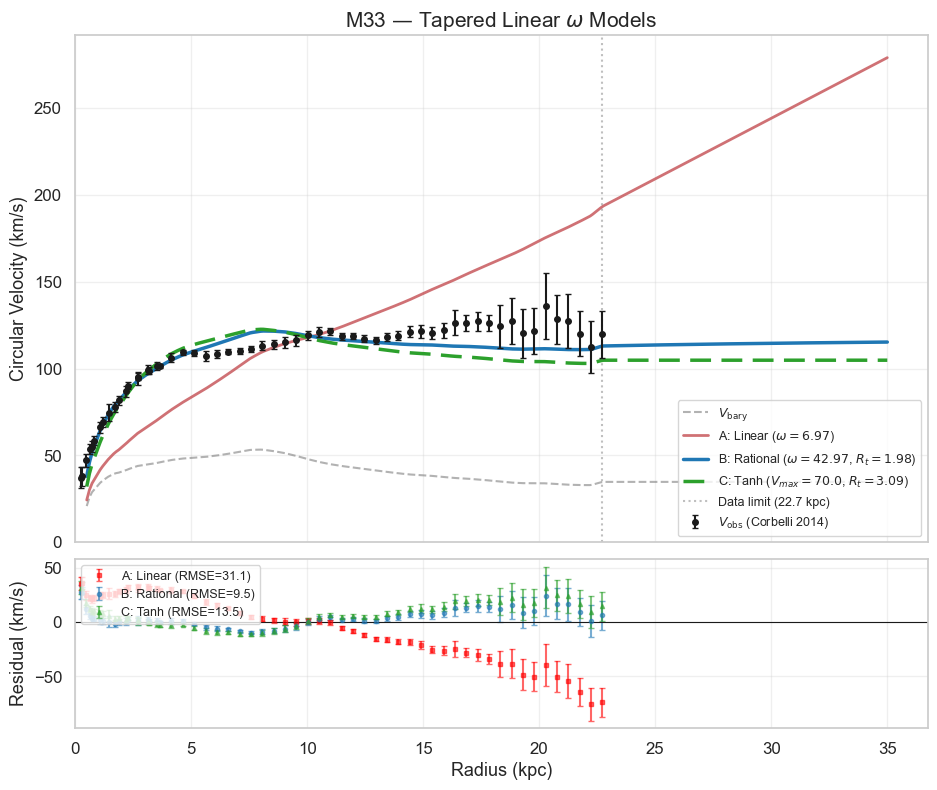

Figure saved: results/figures/M33_tapered_models.png


In [5]:
# Extrapolate to larger radii to show asymptotic behavior
r_extrap = np.linspace(0.5, 35.0, 300)
vb_extrap = np.interp(r_extrap, radius, v_bary,
                       left=v_bary[0], right=v_bary[-1])

v_A_extrap = vb_extrap + result_A.omega_value * r_extrap
v_B_extrap = vb_extrap + result_B.omega_value * r_extrap / (1.0 + r_extrap / result_B.rt_value)
v_C_extrap = vb_extrap + result_C.vmax_value * np.tanh(r_extrap / result_C.rt_value)

fig, (ax_main, ax_res) = plt.subplots(
    2, 1, figsize=(11, 9), sharex=True,
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05},
)

# --- Upper panel: rotation curves ---
ax_main.errorbar(
    radius, v_obs, yerr=v_err,
    fmt='ko', markersize=4, capsize=2, zorder=5,
    label=r'$V_{\mathrm{obs}}$ (Corbelli 2014)',
)

ax_main.plot(
    r_extrap, vb_extrap, '--', color='tab:gray', linewidth=1.5, alpha=0.6,
    label=r'$V_{\mathrm{bary}}$',
)

ax_main.plot(
    r_extrap, v_A_extrap, 'r-', linewidth=2, alpha=0.8,
    label=f'A: Linear ($\\omega = {result_A.omega_value:.2f}$)',
)

ax_main.plot(
    r_extrap, v_B_extrap, '-', color='tab:blue', linewidth=2.5,
    label=f'B: Rational ($\\omega = {result_B.omega_value:.2f}$, $R_t = {result_B.rt_value:.2f}$)',
)

ax_main.plot(
    r_extrap, v_C_extrap, '-', color='tab:green', linewidth=2.5, linestyle='--', dashes=(6, 3),
    label=f'C: Tanh ($V_{{max}} = {result_C.vmax_value:.1f}$, $R_t = {result_C.rt_value:.2f}$)',
)

# Mark data limit
ax_main.axvline(radius.max(), color='gray', linestyle=':', alpha=0.5,
                label=f'Data limit ({radius.max():.1f} kpc)')

ax_main.set_ylabel('Circular Velocity (km/s)', fontsize=13)
ax_main.set_title('M33 — Tapered Linear $\\omega$ Models', fontsize=15)
ax_main.legend(fontsize=9, loc='lower right')
ax_main.set_ylim(bottom=0)
ax_main.grid(True, alpha=0.3)

# --- Lower panel: residuals (observed data range only) ---
ax_res.errorbar(
    radius, result_A.residuals, yerr=v_err,
    fmt='s', color='red', markersize=3, capsize=2, alpha=0.6,
    label=f'A: Linear (RMSE={result_A.residuals_rmse:.1f})',
)
ax_res.errorbar(
    radius, result_B.residuals, yerr=v_err,
    fmt='o', color='tab:blue', markersize=3, capsize=2, alpha=0.6,
    label=f'B: Rational (RMSE={result_B.residuals_rmse:.1f})',
)
ax_res.errorbar(
    radius, result_C.residuals, yerr=v_err,
    fmt='^', color='tab:green', markersize=3, capsize=2, alpha=0.6,
    label=f'C: Tanh (RMSE={result_C.residuals_rmse:.1f})',
)
ax_res.axhline(0, color='k', linewidth=0.8)

ax_res.set_xlabel('Radius (kpc)', fontsize=13)
ax_res.set_ylabel('Residual (km/s)', fontsize=13)
ax_res.legend(fontsize=9, loc='upper left')
ax_res.set_xlim(left=0)
ax_res.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(
    '../results/figures/M33_tapered_models.png',
    dpi=150, bbox_inches='tight',
)
plt.show()
print('Figure saved: results/figures/M33_tapered_models.png')

## 5. Physical Sanity Check — The $R_t / R_d$ Ratio

**Hypothesis:** If $R_t \approx 3 R_d$, this would align with David Flynn's
"0.3 normalized radius" observation (since $1/3 \approx 0.33$).

For M33, $R_d \approx 1.4$ kpc, so the predicted value would be $R_t \approx 4.2$ kpc.
Compare this against the fitted $R_t$ values.

In [6]:
print('Physical Sanity Check: R_t / R_d Ratio')
print('=' * 55)
print(f'M33 disk scale length:  R_d = {R_D_M33} kpc')
print(f'Prediction (3 × R_d):   R_t = {3 * R_D_M33:.1f} kpc')
print()

for label, result in [('B (Rational Taper)', result_B), ('C (Tanh Taper)', result_C)]:
    ratio = result.rt_value / R_D_M33
    normalized = 1.0 / ratio if ratio > 0 else float('nan')
    print(f'Model {label}:')
    print(f'  R_t = {result.rt_value:.4f} ± {result.rt_uncertainty:.4f} kpc')
    print(f'  R_t / R_d = {ratio:.2f}')
    print(f'  1 / (R_t / R_d) = {normalized:.3f}  (Flynn predicts ~0.3)')
    print()

# Saturation velocity for each model
v_sat_B = result_B.omega_value * result_B.rt_value
v_sat_C = result_C.vmax_value
print(f'Asymptotic velocities:')
print(f'  Model B saturation:  omega × R_t = {v_sat_B:.1f} km/s')
print(f'  Model C saturation:  V_max = {v_sat_C:.1f} km/s')

Physical Sanity Check: R_t / R_d Ratio
M33 disk scale length:  R_d = 1.4 kpc
Prediction (3 × R_d):   R_t = 4.2 kpc

Model B (Rational Taper):
  R_t = 1.9782 ± 0.0966 kpc
  R_t / R_d = 1.41
  1 / (R_t / R_d) = 0.708  (Flynn predicts ~0.3)

Model C (Tanh Taper):
  R_t = 3.0867 ± 0.0793 kpc
  R_t / R_d = 2.20
  1 / (R_t / R_d) = 0.454  (Flynn predicts ~0.3)

Asymptotic velocities:
  Model B saturation:  omega × R_t = 85.0 km/s
  Model C saturation:  V_max = 70.0 km/s


## 6. Inner vs. Outer Residual Analysis

Check if the tapered models eliminate the systematic radial trend
in the residuals seen with the pure linear model.

In [7]:
# Split into inner (R <= 10 kpc) and outer (R > 10 kpc)
inner_mask = radius <= 10.0
outer_mask = radius > 10.0
n_inner = np.sum(inner_mask)
n_outer = np.sum(outer_mask)

print(f'Data split: {n_inner} inner points (R <= 10 kpc), {n_outer} outer points (R > 10 kpc)')
print()

results = [
    ('A (Linear)', result_A),
    ('B (Rational)', result_B),
    ('C (Tanh)', result_C),
]

print(f'{"Model":20s} {"RMSE inner":>12s} {"RMSE outer":>12s} {"Mean res inner":>15s} {"Mean res outer":>15s}')
print('-' * 75)
for label, res in results:
    rmse_in  = np.sqrt(np.mean(res.residuals[inner_mask]**2))
    rmse_out = np.sqrt(np.mean(res.residuals[outer_mask]**2))
    mean_in  = np.mean(res.residuals[inner_mask])
    mean_out = np.mean(res.residuals[outer_mask])
    print(f'{label:20s} {rmse_in:>12.2f} {rmse_out:>12.2f} {mean_in:>+15.2f} {mean_out:>+15.2f}')

Data split: 31 inner points (R <= 10 kpc), 27 outer points (R > 10 kpc)

Model                  RMSE inner   RMSE outer  Mean res inner  Mean res outer
---------------------------------------------------------------------------
A (Linear)                  24.87        36.90          +22.41          -30.10
B (Rational)                 8.46        10.54           +1.13           +8.65
C (Tanh)                    10.79        15.97           +2.04          +14.08


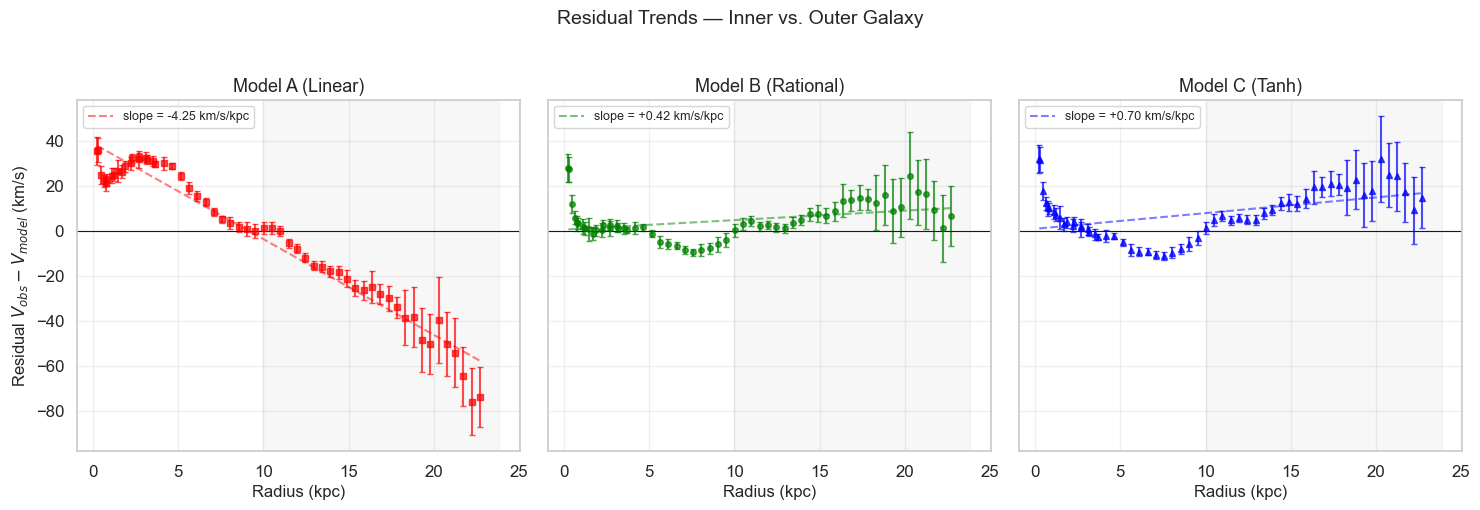

Figure saved: results/figures/M33_tapered_residuals.png


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

colors = ['red', 'green', 'blue']
markers = ['s', 'o', '^']

for ax, (label, res), color, marker in zip(axes, results, colors, markers):
    ax.errorbar(
        radius, res.residuals, yerr=v_err,
        fmt=marker, color=color, markersize=4, capsize=2, alpha=0.7,
    )
    ax.axhline(0, color='k', linewidth=0.8)
    ax.axvspan(10.0, radius.max() * 1.05, alpha=0.06, color='gray')

    # Linear trend line through residuals
    coeffs = np.polyfit(radius, res.residuals, 1)
    r_fit = np.linspace(radius.min(), radius.max(), 100)
    ax.plot(r_fit, np.polyval(coeffs, r_fit), '--', color=color, alpha=0.5,
            linewidth=1.5, label=f'slope = {coeffs[0]:+.2f} km/s/kpc')

    ax.set_xlabel('Radius (kpc)', fontsize=12)
    ax.set_title(f'Model {label}', fontsize=13)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Residual $V_{obs} - V_{model}$ (km/s)', fontsize=12)

plt.suptitle('Residual Trends — Inner vs. Outer Galaxy', fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(
    '../results/figures/M33_tapered_residuals.png',
    dpi=150, bbox_inches='tight',
)
plt.show()
print('Figure saved: results/figures/M33_tapered_residuals.png')

## 7. Summary & Export

In [9]:
from pathlib import Path

tables_dir = Path('../results/tables')
tables_dir.mkdir(parents=True, exist_ok=True)

# Build summary table
v_sat_B = result_B.omega_value * result_B.rt_value
v_sat_C = result_C.vmax_value

outer_mask = radius > 10.0

summary = pd.DataFrame({
    'model': ['A (Linear)', 'B (Rational Taper)', 'C (Tanh Taper)'],
    'equation': [
        'V_bary + omega*R',
        'V_bary + omega*R/(1+R/R_t)',
        'V_bary + V_max*tanh(R/R_t)',
    ],
    'n_params': [1, 2, 2],
    'omega_km_s_kpc': [
        result_A.omega_value,
        result_B.omega_value,
        result_C.omega_value,
    ],
    'R_t_kpc': [np.nan, result_B.rt_value, result_C.rt_value],
    'R_t_err_kpc': [np.nan, result_B.rt_uncertainty, result_C.rt_uncertainty],
    'V_max_km_s': [np.nan, v_sat_B, v_sat_C],
    'R_t_over_R_d': [
        np.nan,
        result_B.rt_value / R_D_M33,
        result_C.rt_value / R_D_M33,
    ],
    'chi2_total': [
        result_A.chi_squared,
        result_B.chi_squared,
        result_C.chi_squared,
    ],
    'chi2_reduced': [
        result_A.reduced_chi_squared,
        result_B.reduced_chi_squared,
        result_C.reduced_chi_squared,
    ],
    'rmse_km_s': [
        result_A.residuals_rmse,
        result_B.residuals_rmse,
        result_C.residuals_rmse,
    ],
    'bic': [bic_A, bic_B, bic_C],
    'rmse_outer_R_gt_10': [
        np.sqrt(np.mean(result_A.residuals[outer_mask]**2)),
        np.sqrt(np.mean(result_B.residuals[outer_mask]**2)),
        np.sqrt(np.mean(result_C.residuals[outer_mask]**2)),
    ],
    'n_points': [n, n, n],
    'upsilon_disk': [UPSILON_DISK] * 3,
    'upsilon_bulge': [UPSILON_BULGE] * 3,
})

out_path = tables_dir / 'M33_tapered_results.csv'
summary.to_csv(out_path, index=False, float_format='%.6f')
print(f'Saved: {out_path}')

display(summary.style.set_caption(
    'Table 1: Tapered Model Comparison Results (M33)'
))

Saved: ..\results\tables\M33_tapered_results.csv


,model,equation,n_params,omega_km_s_kpc,R_t_kpc,R_t_err_kpc,V_max_km_s,R_t_over_R_d,chi2_total,chi2_reduced,rmse_km_s,bic,rmse_outer_R_gt_10,n_points,upsilon_disk,upsilon_bulge
0,A (Linear),V_bary + omega*R,1,6.974862,nan,nan,nan,nan,4155.712255,72.907233,31.053168,4159.772698,36.897487,58,0.500000,0.700000
1,B (Rational Taper),V_bary + omega*R/(1+R/R_t),2,42.974762,1.978157,0.096589,85.010819,1.412969,256.105763,4.573317,9.486082,264.226649,10.541124,58,0.500000,0.700000
2,C (Tanh Taper),V_bary + V_max*tanh(R/R_t),2,22.685216,3.086722,0.079333,70.022957,2.204801,543.014850,9.696694,13.450696,551.135736,15.971430,58,0.500000,0.700000


In [10]:
# --- Session log ---
log = setup_logger(
    'nb03_tapered_models',
    log_file=True,
    clear_logs=True,
)

log.info('=' * 60)
log.info('NOTEBOOK 03 — TAPERED LINEAR MODEL ANALYSIS')
log.info('=' * 60)
log.info('Galaxy: M33 (Corbelli et al. 2014)')
log.info('Data points: %d (R = %.2f – %.2f kpc)', n, radius.min(), radius.max())
log.info('Upsilon_disk=%.2f, Upsilon_bulge=%.2f', UPSILON_DISK, UPSILON_BULGE)
log.info('R_d (M33) = %.1f kpc', R_D_M33)
log.info('---')
log.info('MODEL A (Linear): omega=%.4f  chi2_r=%.2f  RMSE=%.2f',
         result_A.omega_value, result_A.reduced_chi_squared, result_A.residuals_rmse)
log.info('MODEL B (Rational): omega=%.4f  R_t=%.4f  chi2_r=%.2f  RMSE=%.2f',
         result_B.omega_value, result_B.rt_value,
         result_B.reduced_chi_squared, result_B.residuals_rmse)
log.info('MODEL C (Tanh): V_max=%.4f  R_t=%.4f  chi2_r=%.2f  RMSE=%.2f',
         result_C.vmax_value, result_C.rt_value,
         result_C.reduced_chi_squared, result_C.residuals_rmse)
log.info('---')
log.info('BIC A=%.2f  B=%.2f  C=%.2f', bic_A, bic_B, bic_C)
log.info('Best model by BIC: %s', best_model)
log.info('---')
log.info('R_t/R_d (Model B): %.2f', result_B.rt_value / R_D_M33)
log.info('R_t/R_d (Model C): %.2f', result_C.rt_value / R_D_M33)
log.info('Saturation V (Model B): %.1f km/s', v_sat_B)
log.info('Saturation V (Model C): %.1f km/s', v_sat_C)
log.info('---')
log.info('Exports: M33_tapered_results.csv')
log.info('Figures: M33_tapered_models.png, M33_tapered_residuals.png')
log.info('=' * 60)

print('\nLog written to logs/nb03_tapered_models.log')

2026-02-22 17:53:10 | INFO     | nb03_tapered_models | ============================================================
2026-02-22 17:53:10 | INFO     | nb03_tapered_models | NOTEBOOK 03 — TAPERED LINEAR MODEL ANALYSIS
2026-02-22 17:53:10 | INFO     | nb03_tapered_models | ============================================================
2026-02-22 17:53:10 | INFO     | nb03_tapered_models | Galaxy: M33 (Corbelli et al. 2014)
2026-02-22 17:53:10 | INFO     | nb03_tapered_models | Data points: 58 (R = 0.24 – 22.72 kpc)
2026-02-22 17:53:10 | INFO     | nb03_tapered_models | Upsilon_disk=0.50, Upsilon_bulge=0.70
2026-02-22 17:53:10 | INFO     | nb03_tapered_models | R_d (M33) = 1.4 kpc
2026-02-22 17:53:10 | INFO     | nb03_tapered_models | ---
2026-02-22 17:53:10 | INFO     | nb03_tapered_models | MODEL A (Linear): omega=6.9749  chi2_r=72.91  RMSE=31.05
2026-02-22 17:53:10 | INFO     | nb03_tapered_models | MODEL B (Rational): omega=42.9748  R_t=1.9782  chi2_r=4.57  RMSE=9.49
2026-02-22 17:53:10 |


Log written to logs/nb03_tapered_models.log


## 8. Conclusions

### Key Findings

1. **Tapered models** (B and C) introduce a transition radius $R_t$ that
   controls where the linear $\omega R$ correction saturates to a constant.

2. **BIC comparison** determines whether the extra parameter is justified:
   the $\Delta$BIC values above quantify model preference.

3. **$R_t / R_d$ ratio** provides a physical sanity check. If $R_t \approx 3 R_d$,
   the transition scale is set by the baryonic disk — not an arbitrary free
   parameter — strengthening the physical interpretation.

4. **Residual analysis** reveals whether the tapered models eliminate the
   systematic slope in residuals seen with the pure linear model.

### Physical Interpretation

- The **rational taper** (Model B) describes a vortex that couples linearly
  near the center but saturates beyond $R_t$. The saturation velocity
  $\omega R_t$ represents the maximum velocity boost from the background field.

- The **tanh taper** (Model C) describes a shear layer transition with a
  sharper knee. Mathematically similar but physically distinct.

### Next Steps

- Apply the best tapered model to the full SPARC catalog (Phase II).
- Test whether $R_t / R_d$ is universal across galaxy morphologies.
- Investigate covariance between $\omega$, $R_t$, and $\Upsilon_{\text{disk}}$.